## RAMA 2: Vamos a estudiar el hamiltoniano asociado a una cadena de moléculas sin interacción dipolar. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sympy as sp
from qutip import *
from qutip import (about, destroy, entropy_vn, expect, hinton, jmat, ptrace, qeye, steadystate, tensor, wigner)
from mpl_toolkits.mplot3d import Axes3D # hacer gráfico 3Dfrom numpy import *
%matplotlib inline
from numpy import *
from scipy.misc import *
from scipy.special import *

In [3]:
def a0(x): #esta función convierte una distancia x en metros a unidades atómicas a_0
    return x/(5.29177249e-11) 
#########

def tau(t): #convertir de segundos a tiempo en unidades atómicas
    return t/2.418884332268184938e-17

##################

def dby(d): #d está en debyes, pasamos a unidades atómocas ea_0
    return (d*0.393430307)


def Fre(nu): 
    return (nu/6.579683905044601137e15)


def Freo(omega):
    return (omega/4.13413732380622433e16)


def Eh(E): #se ingresa una energía en eV la devuelve en E_h
    
    return E/ 27.211386245988

In [9]:
##### para los coeficientes

def tau(n,i,l):
    r=k[i]*a[l]
    return spherical_jn(n,r)

def h(n,i,l):
    r=k[i]*a[l]
    return spherical_jn(n,r) + 1j * spherical_yn(n,r)


def Ptau(n,i,l):
    return (n*tau(n-1,i,l)-(n+1)*tau(n+1, i, l))/(2*n+1)+tau(n, i, l)/(k[i]*a[l])

def Ph(n, i, l):
    return (n*h(n-1,i,l)-(n+1)*h(n+1, i, l))/(2*n+1)+h(n, i, l)/(k[i]*a[l])
 
def T(n, B):

    f=0
            
    if B=='H':
        return  ( k[f+1]*(Ptau(n, f+1,f)*h(n, f+1, f)-tau(n, f+1, f)*Ph(n, f+1, f)) )/( k[f+1]*Ptau(n, f+1,f)*h(n, f, f)- k[f]*tau(n, f+1, f)*Ph(n, f, f))
        
    if B=='V':
        return  ( k[f+1]*(tau(n, f+1,f)*Ph(n, f+1, f)-Ptau(n, f+1, f)*h(n, f+1, f)) )/( k[f+1]*tau(n, f+1,f)*Ph(n, f, f)- k[f]*Ptau(n, f+1, f)*h(n, f, f))

        

def AM(n):
    return T(n, 'H')

def AN(n):
    return T(n, 'V')

In [10]:
a=[R*(1+alpha), R]  
k=[np.sqrt(epsilon_2)*omega_p/137, omega_p/137]

In [11]:
def Plpmv(n,m,theta): #derivative of the associated Legendre polinomials 

    return ((n*np.cos(theta)*lpmv(n, m, np.cos(theta))-(n+m)*lpmv(n-1,m, np.cos(theta)))/np.sqrt((1-np.cos(theta)**2)) )

def h(n, u): #spherical Hankel function of the first kind 
    return spherical_jn(n,u) + 1j * spherical_yn(n,u)

def M(A,B,m, n, k, R): #(e,o), (p, np) 

    result=[0] #no tenemos componente radial
    r=R[0]
    theta=R[1]
    phi=R[2]

    hn=spherical_jn(n,k*r) +1j*spherical_yn(n,k*r)

    if A=='e':
    
        if B=='p':
            result.append( -m/(np.sin(theta))*(hn)*lpmv(m, n, np.cos(theta))*np.sin(m*phi) )
            result.append( -hn*Plpmv(n,m,theta) *np.cos(m*phi)  )
        else:
            result.append( -m/(np.sin(theta))*(spherical_jn(n, k*r))*lpmv(m, n, np.cos(theta))*np.sin(m*phi))
            result.append( -spherical_jn(n, k*r)*Plpmv(n,m,theta) *np.cos(m*phi)  )

    if A=='o':

        if B=='p':
            result.append( m/(np.sin(theta))*(hn)*lpmv(m, n, np.cos(theta))*np.cos(m*phi) )
            result.append( -hn*Plpmv(n,m,theta) *np.sin(m*phi)  )
        else:
            result.append( m/(np.sin(theta))*(spherical_jn(n, k*r))*lpmv(m, n, np.cos(theta))*np.cos(m*phi))
            result.append( -spherical_jn(n, k*r)*Plpmv(n,m,theta)*np.sin(m*phi) )

    return result




def N(A,B,m, n, k, R): # (e,o), (p, np) 

    result=[] 
    r=R[0]
    theta=R[1]
    phi=R[2]


    Pj= (n*spherical_jn(n-1, k*r)-(n+1)*spherical_jn(n+1, k*r))/(2*n+1)+spherical_jn(n, k*r)/(k*r)

    Ph= (n*h(n-1, k*r)-(n+1)*h(n+1, k*r))/(2*n+1)+h(n, k*r)/(k*r)

    if A=='e':
    
        if B=='p':
            result.append( n*(n+1)/(k*r)*h(n, k* r)*lpmv(m, n, np.cos(theta))*np.cos(m*phi) )

            result.append( Ph*Plpmv(n,m,theta) *np.cos(m*phi)  )

            result.append(-Ph*(m/np.sin(theta))*lpmv(m, n, np.cos(theta))*np.sin(m*phi)) 

        else:
            result.append( n*(n+1)/(k*r)*spherical_jn(n, k*r)*lpmv(m, n, np.cos(theta))*np.cos(m*phi) )

            result.append(  Pj*Plpmv(n,m,theta) *np.cos(m*phi)  )

            result.append( -Pj*(m/np.sin(theta))*lpmv(m, n, np.cos(theta))*np.sin(m*phi)  ) 

    if A=='o':

        if B=='p':
            result.append( n*(n+1)/(k*r)*h(n, k*r)*lpmv(m, n, np.cos(theta))*np.sin(m*phi) )

            result.append( Ph*Plpmv(n,m,theta) *np.sin(m*phi)  )

            result.append(Ph*(m/np.sin(theta))*lpmv(m, n, np.cos(theta))*np.cos(m*phi)) 

        else:
            result.append( n*(n+1)/(k*r)*spherical_jn(n, k*r)*lpmv(m, n, np.cos(theta))*np.sin(m*phi) )

            result.append(Pj*Plpmv(n,m,theta) *np.sin(m*phi)  )

            result.append( Pj*(m/np.sin(theta))*lpmv(m, n, np.cos(theta))*np.cos(m*phi)  ) 

    return result

# **ACÁ INICIA EL CÓDIGO**

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sympy as sp
from qutip import *
from qutip import (about, destroy, entropy_vn, expect, hinton, jmat, ptrace, qeye, steadystate, tensor, wigner)
from mpl_toolkits.mplot3d import Axes3D # hacer gráfico 3Dfrom numpy import *
%matplotlib inline
from numpy import *

In [3]:
def a0(x): #esta función convierte una distancia x en metros a unidades atómicas a_0
    return x/(5.29177249e-11) 
#########

def tau(t): #convertir de segundos a tiempo en unidades atómicas
    return t/2.418884332268184938e-17

##################

def dby(d): #d está en debyes, pasamos a unidades atómocas ea_0
    return (d*0.393430307)


def Freo(omega):
    return (omega/4.13413732380622433e16)


In [4]:
#parámetros del sistema
M=15
N=100

#parámetros de la nano esfera

c= 299792458
nu=c/197.49e-9

omega_p=Freo(2*np.pi*nu) #se ingresa en eV, luego se transforma en Hartrees. 
omega_m=omega_p

R=a0(10e-9) #urgente determinar el R asociado a una frecuencia dada. 

epsilon_2=6.05

d=dby(1.811)  #el dipolo se ingresa en debyes

r=a0(6.27e-10)   #distancia natural entre dipolos

alpha=0.05

A=(1+alpha)*R

Calculemos el número de dipolos alrededor de la nanoesfera en una primera capa

In [5]:
delta=np.arcsin(r/(R+r))
theta=np.arange(delta, np.pi/2-delta, delta)

num=0
ang=delta

for k in theta:
    num+=2*np.pi*np.sin(ang)*(R+r)/r
    ang+=k


print(2*num)
print( 2*np.pi*(R+r)/r )

668.8577927644662
106.49347728771527


In [6]:
def posiciones2(y, M):

    r=[]
    
    phi=np.linspace(0, 2*np.pi, M)
    theta=np.pi/2

    for i in phi:

        X=y*np.cos(i)
        Y=y*np.sin(i)
        Z=y*np.cos(theta)
        r.append([X,Y,Z])
       

    return np.array(r)


# Función para encontrar los vectores aleatorios que definen cada momento

In [7]:
def Momentos2(T): #todos los momentos están en la dirección de la posición
 
    momentos=[]
    
    for i in T:
        momentos.append( i/np.linalg.norm(i) ) #vector que en cada componente tiene en ángulo theta y phi asociado 
    return (np.real(momentos))


In [8]:
y=R+a0(6.27e-10) 
M=106
P=posiciones2(y, M)
momentos=Momentos2(P)  


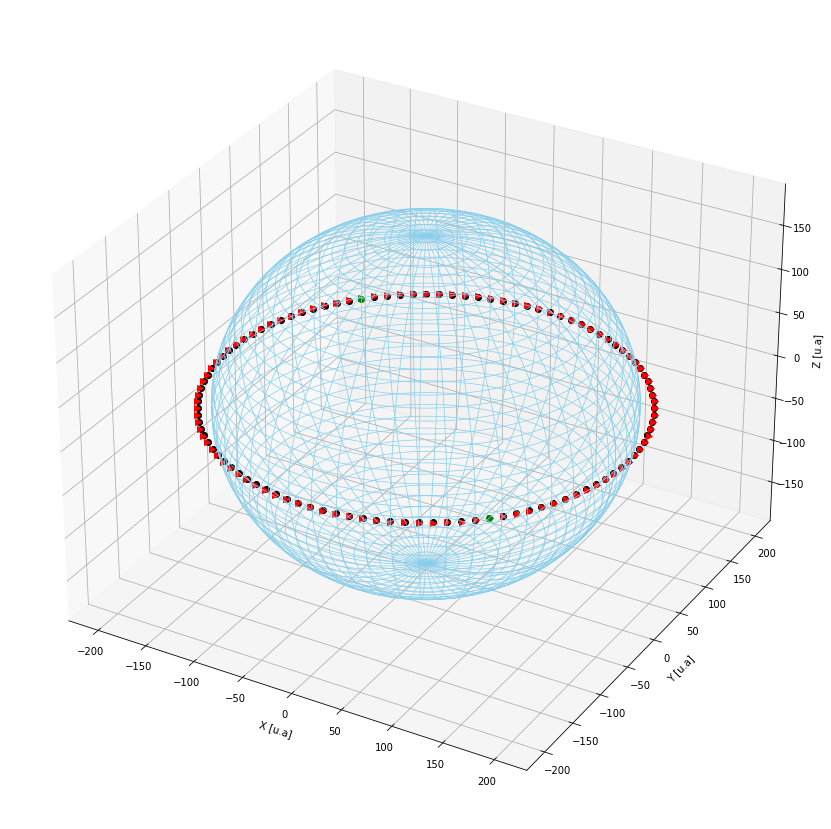

In [9]:
fig, ax=plt.subplots(figsize=(15,15), subplot_kw=dict(projection='3d'))


#graficamos la nanoesfera
theta=np.linspace(0,np.pi,100)
phi=np.linspace(0,2*np.pi,100)

Theta,Phi=np.meshgrid(theta,phi)

X=R*np.sin(Theta)*np.cos(Phi) 
Y=R*np.sin(Theta)*np.sin(Phi)
Z=R*np.cos(Theta)

ax.plot_wireframe(X,Y,Z,lw=0.7, color='skyblue') #dibujamos el casquete esférico

#graficamos los dipolos y su dirección
for i in range (len(P)): #en P están los centros de masa de los momentos
    #en momentos está el vector del momento. 
    
    if i==40 or i==92: 
        x1=momentos[i][0]+P[i][0]
        y1=momentos[i][1]+P[i][1]
        z1=momentos[i][2]+P[i][2]

        ax.plot((P[i][0],),(P[i][1],), (P[i][2],), marker='o',c='g') #dibujamos el centro del dipolo
        ax.plot((P[i][0], x1 ) ,(P[i][1],y1), (P[i][2],z1  ),  c='g') #dibujamos la línea
        ax.plot((x1,),(y1,),(z1,),'->',c='g') #dibujamos la dirección
    else: 
        x1=momentos[i][0]+P[i][0]
        y1=momentos[i][1]+P[i][1]
        z1=momentos[i][2]+P[i][2]

        ax.plot((P[i][0],),(P[i][1],), (P[i][2],), marker='o',c='k') #dibujamos el centro del dipolo
        ax.plot((P[i][0], x1 ) ,(P[i][1],y1), (P[i][2],z1  ),  c='r') #dibujamos la línea
        ax.plot((x1,),(y1,),(z1,),'->',c='r') #dibujamos la dirección
    
        
 

ax.set_xlabel('X [u.a]')
ax.set_ylabel('Y [u.a]')
ax.set_zlabel('Z [u.a]')
plt.show()

# Función para determinar $\hat{\sigma}_+, \hat{\sigma}_-, \hat{\sigma}_3$ de cada dipolo

In [10]:
def sigmaT(M,N):
    l = 2  # número de estados del dipolo. 
    Sigma = []
    for i in range(M):
        operators = []
        for j in range(M): #si el índice es igual a la matriz que quiero entonces pongo el destroy 
            #de resto pongo el qeye, l
            # uego al final pongo la matriz unitaria asociada a la radiación.
            if j != i:
                operators.append(qeye(l))
            else:
                operators.append(destroy(l))
        
        operators.append(qeye(N+1))
        sigma_plus=tensor(operators)
        Sigma.append(np.array(sigma_plus))

    return np.real(Sigma)

In [11]:
def Base(M,N):
    B=np.eye(2**M*(N+1))
    return np.linalg.eig(B)[1]

In [12]:
def aT(M,N): #función que entrega la representación matricial del operador a en la base de 
    #N fotones y M dipolos. 
    L=[]
    for i in range(M):
        L.append(qeye(2))
    L.append(destroy(N+1))
    a=tensor(L) 
    return (np.real(np.array(a)))

In [13]:
def Hdip0(M, sigmas):
    
    s=sigmas[0].shape
    H_0=np.zeros((s))
    
    for i in range (M):
        sp=sigmas[i]
        sm=np.transpose(sp)
        H_0+=sp@sm-sm@sp
        
    return (0.5*omega_m*H_0 )

In [14]:
def vecinos(i, M):
    if i >= M:
        return "error"
    V = []
    if i != M - 1:
        V.append(i + 1)
    return V

In [15]:
def vecinosp(i, M):

    V=vecinos(i, M)
    
    if i==0: 
        V.append(M-1)       
    return V

In [16]:
def Ein(i, M, Momentos, sigmas): 
    """
    siempre consideramos situaciones sin RWA y con condiciones de frontera periodicas
    """ 

    V = vecinosp(i, M)
        
    
    sum1 = 0
    sum2 = 0
    
    s = sigmas[0].shape

    if M == 1:
        return np.zeros(s)
    
    
    if V:

        for k in V:
            sum1 += (sigmas[i] + np.transpose(sigmas[i])) @ (sigmas[k] + np.transpose(sigmas[k]))
            sum2 += np.dot(Momentos[i], Momentos[k])-3*np.dot(Momentos[i], [1,0,0])*np.dot(Momentos[k], [1,0,0])
        
        return sum2*sum1

    else:
        return np.zeros(s)

In [47]:
def HdipI(M, momentos, sigmas):   

    if M==0:
        return  np.zeros(sigmas[0].shape)

    else:
        s=sigmas[0].shape
        H_2=np.zeros((s))
        
        for i in range (M):
            H_2+=Ein(i,M,momentos, sigmas) 
        
    return (d**2/r**3)*H_2

Para poder lograr un acople fuerte entre dipolos necesitaríamos 105 dipolos alrededor de la nanoesfera, sino la estructura del hamiltoniano no se ve afectada. 

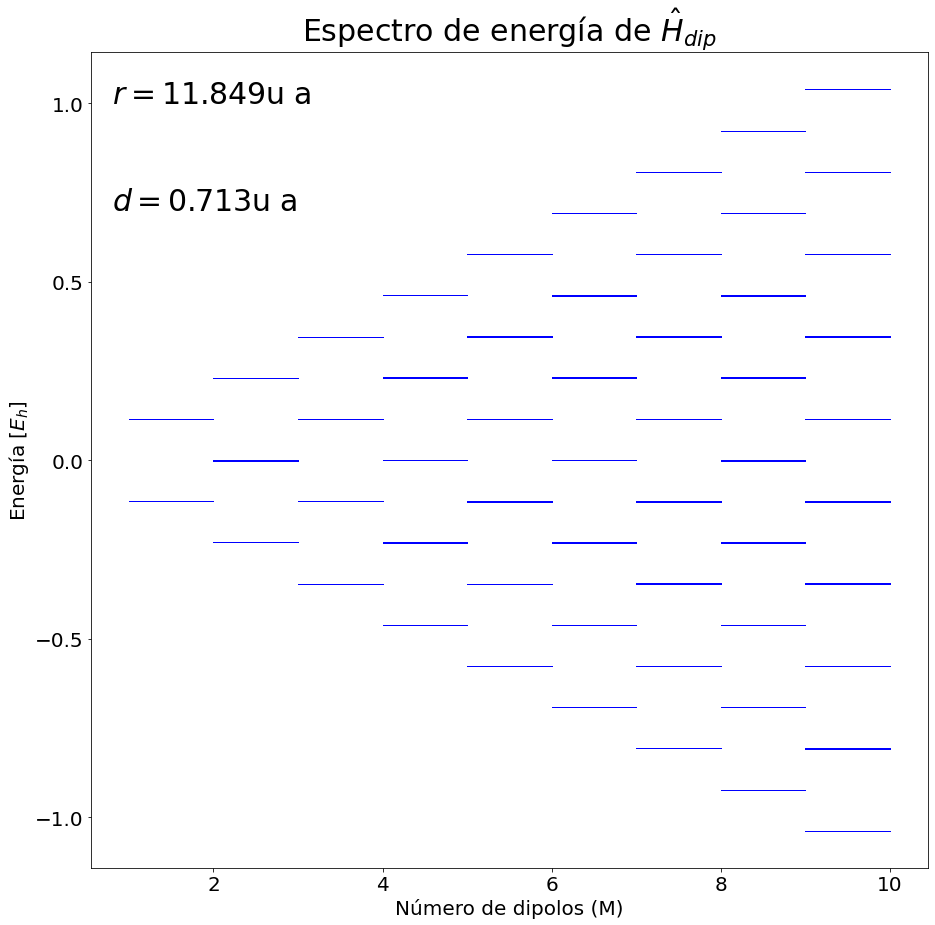

In [29]:
#parámetros de la nano esfera

c= 299792458
nu=c/197.49e-9

omega_p=Freo(2*np.pi*nu) #se ingresa en eV, luego se transforma en Hartrees. 
omega_m=omega_p

R=a0(10e-9) #urgente determinar el R asociado a una frecuencia dada. 

epsilon_2=6.05

d=dby(1.811)  #el dipolo se ingresa en debyes y se convierte a unidades atómicas

r=a0(6.27e-10)   #distancia natural entre dipolos


M=9
N=0

momentos=Momentos2(M)
sigmas=sigmaT(M, N)

fig1,ax1=plt.subplots(1,1, figsize=(15,15))


for i in range(1, M+1):
    U0=Hdip0(i, sigmas)
    U1=HdipI(i, momentos, sigmas)
    
    E0=np.real(np.linalg.eigvals(U0))
    E1=np.real(np.linalg.eigvals(U1))
    E2=np.real(np.linalg.eigvals(U0+U1))


    for j in range(len(E2)):
        X=[int(i), int(i+1)]
        ax1.plot(X,[E2[j],E2[j]], c='b', lw=1) 
        #ax1.plot(X,[E0[j],E0[j]], c='k')
        
              

ax1.set_xlabel('Número de dipolos (M)', fontsize=20)
ax1.set_ylabel(r'Energía$~[E_h]$', fontsize=20)
ax1.set_title('Espectro de energía de $\hat{H}_{dip}$', fontsize=30)
ax1.text(0.8, 0.7, '$d=${}u a'.format(np.round(d,3)), fontsize=30)
ax1.text(0.8, 1, '$r=${}u a'.format(np.round(r,3)), fontsize=30)


ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)


plt.show()
fig1.savefig('Energía_dipolos.png', format='png', bbox_inches='tight')

### La correción a la energía debido a la interacción entre dipolos es fuertemente dependiente de la magnitud de los dipolos, en nuestro caso, incluso a la distancia mínima de separación  no se observa un cambio significativo en la energía. 

# hamiltoniano radiación-materia  en la base completa

### 

\begin{align} 
 \hat{H}_{tot}= \frac{\omega_m}{2} \sum_{i=1}^{  M } \hat{\sigma}_{3j}+\omega_p \hat{a}^{\dagger}\hat{a} + \frac{3}{2}d\sqrt{\frac{3 \omega_p R^3}{
  (2\epsilon_2+1)^{3/2}}} \left[\sum_{i=1}^{M}\sum_{\hat{k}=\hat{x}, \hat{y}, \hat{z}} \frac{ (3 \cos \theta_{0_ik} \cos \theta_{0_id_i}-\cos \theta_{d_ik}) }{r_{0d_i}^3}(\hat{\sigma}_{+i}+\hat{\sigma}_{-i}) \right ] (\hat{a}+\hat{a}^\dagger) 
\end{align}

In [18]:
def Hrad0(a):
    return omega_p*(np.transpose(a)@a)

Vamos a definir una función que nos permita conocer para diferentes configuraciones de M dipolos entre qué valos varía el factor lamnda

In [19]:
def landa2 (M,  P): #valor del factor de acople 
 
    K=np.array([[1,0,0], [0,1,0],[0,0,1]])

    result=[]
    momentos=Momentos2(P)
        
    for i in range(M):

        Landa=0
        p= (1/y)*P[i]

        m=momentos[i]

        for k in K:
            Landa+=3*np.dot(p,k)*np.dot(p,m)-np.dot(m,k)

        result.append(3*d*np.sqrt((3*omega_p*R**3)/(2*epsilon_2+1)**(3/2))*(1/y**3)*np.abs(Landa))



    
    return (result, np.sum(result))

Determinemos cuántos dipolos necesito para logragr strong coupling en mi sistema. 

## Mientras más pequeña sea la nanoesfera mayor es el valor de lambda, es decir, mayor es el acople entre los dipolos y el campo.

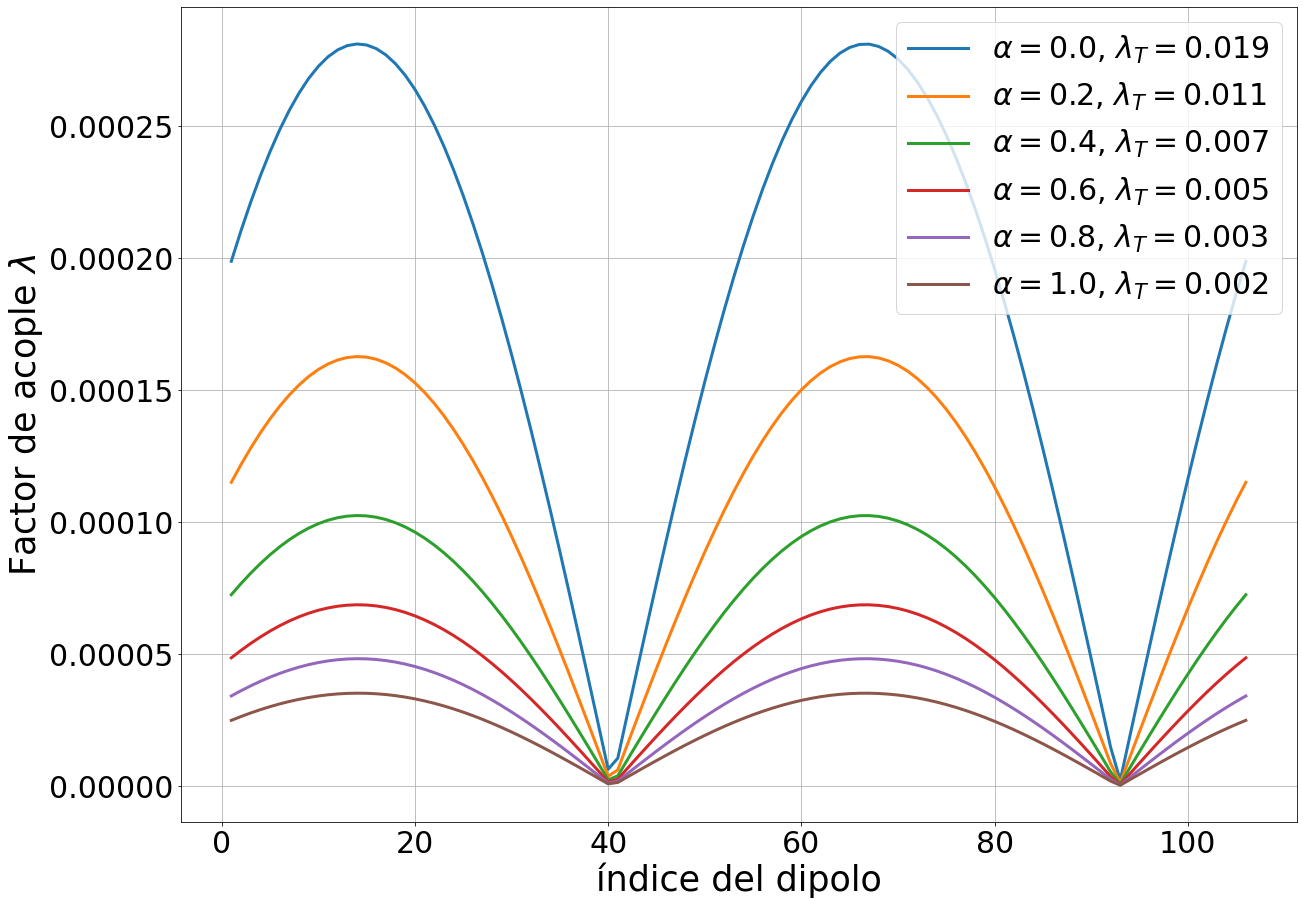

In [33]:
c= 299792458
nu=c/197.49e-9
omega_p=Freo(2*np.pi*nu) #se ingresa en eV, luego se transforma en Hartrees. 
R=a0(10e-9) #urgente determinar el R asociado a una frecuencia dada. 
epsilon_2=6.05
d=dby(1.811)  #el dipolo se ingresa en debyes

M=106

alpha=np.arange(0, 1.2, 0.2)


fig, ax= plt.subplots(figsize=(20,15))



for i in alpha: 
    Resultado=[]
    y=R*(1+i)
    P=posiciones2(y, M)
    KK=landa2(M, P)
    ax.plot( np.arange(1, M+1), KK[0], label=r'$\alpha=${}, $\lambda_T=${}'.format(np.round(i,3),  np.round(KK[1],3)   ), lw=3)


ax.set_xlabel('índice del dipolo', fontsize=35)
ax.set_ylabel(r'Factor de acople $\lambda$', fontsize=35)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)

ax.legend(fontsize=30)
ax.grid()
fig.savefig('lambda.png', format='png', bbox_inches='tight')
plt.show()

## Los ceros de $\lambda$ indican que no se da acople dipolar, es decir, es esos casos los dipolos se acoplan con modos multipolares del campo asociados a procesos no radiativos. 

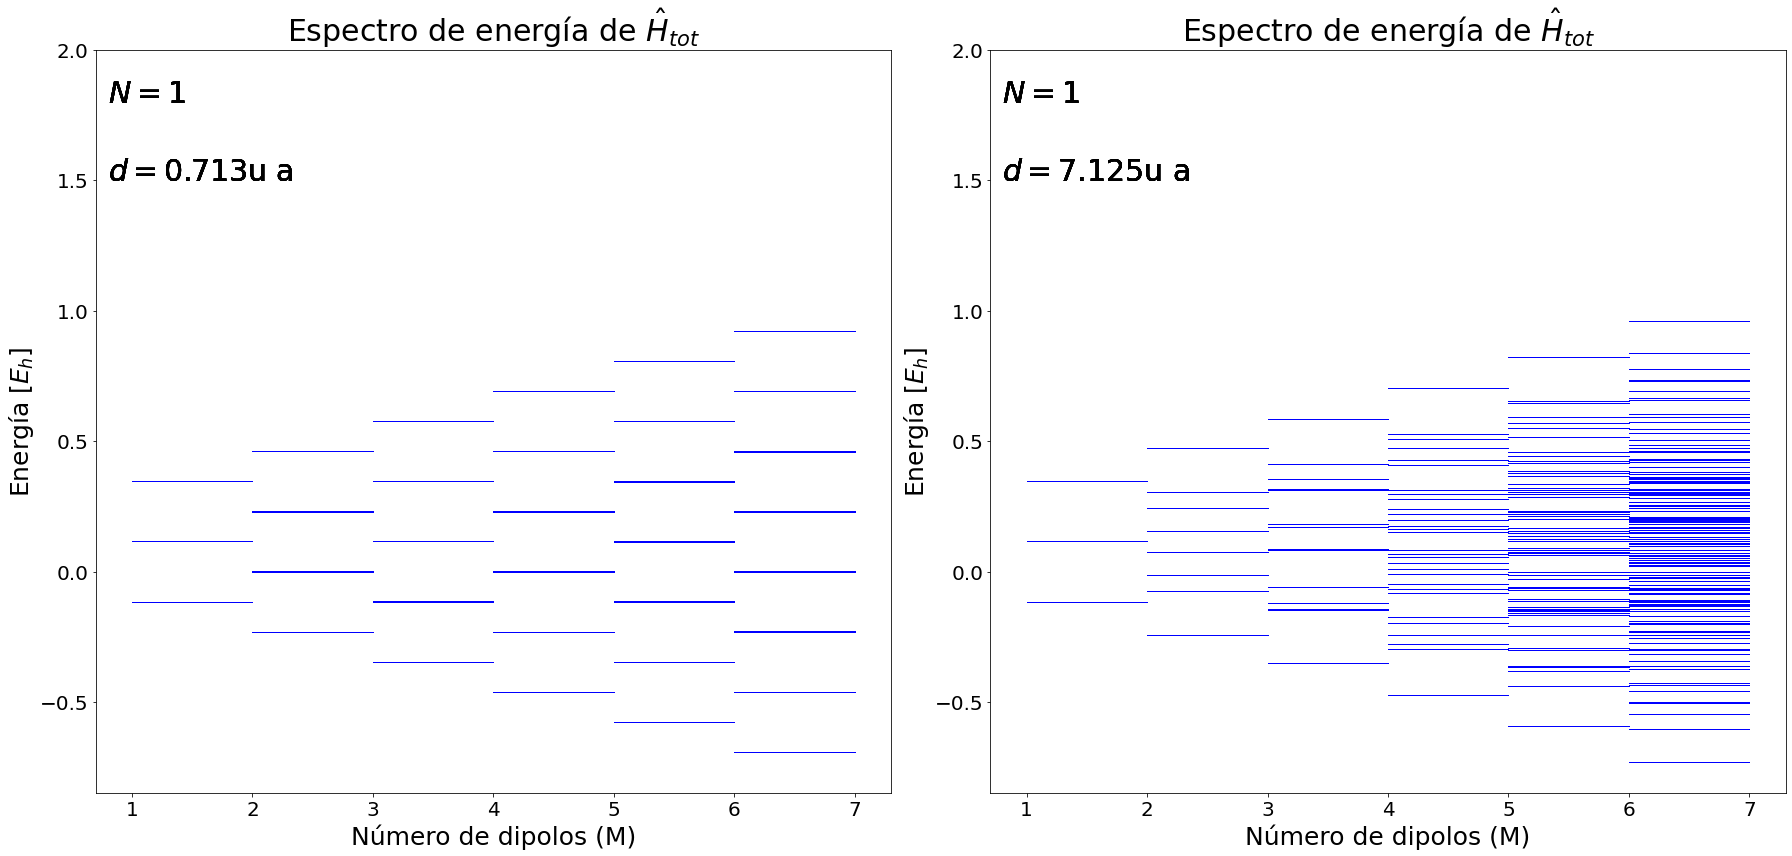

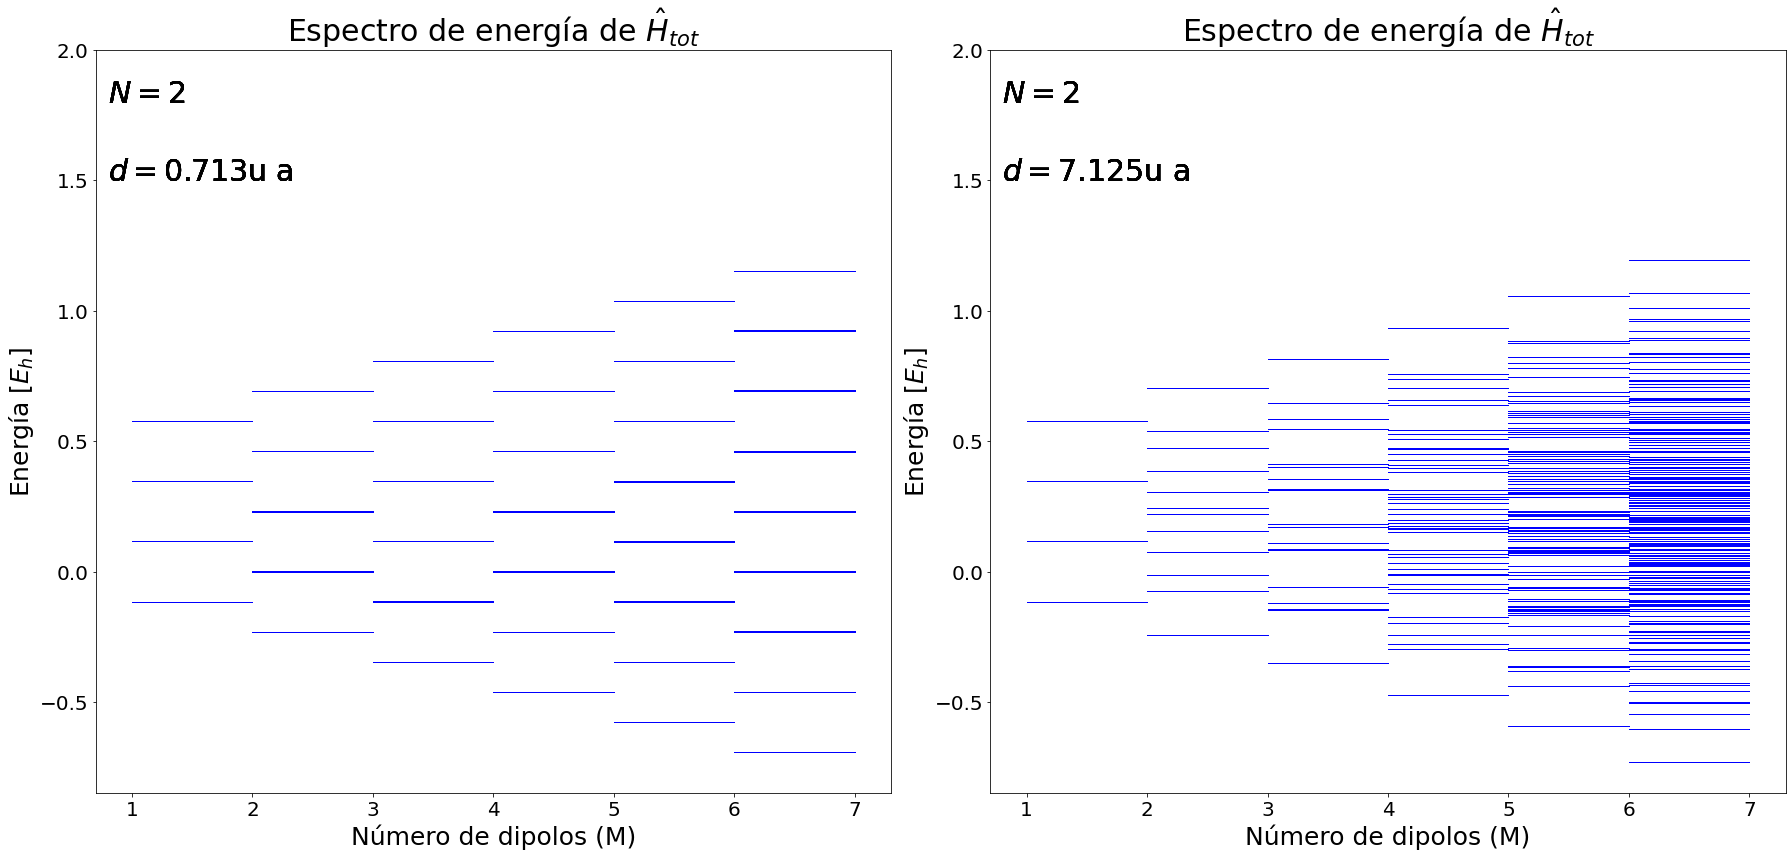

In [30]:
nu=c/197.49e-9
omega_p=Freo(2*np.pi*nu) #se ingresa en eV, luego se transforma en Hartrees. 
omega_m=omega_p
R=a0(10e-9) #urgente determinar el R asociado a una frecuencia dada. 
epsilon_2=6.05
d=dby(1.811)  #el dipolo se ingresa en debyes

y=R+a0(6.27e-10) 
M=6
P=posiciones2(y, M)
momentos=Momentos2(P)

D=[d, 10*d]

for N in range(1, 3):

    sigmas= sigmaT(M,N)
    a=aT(M,N)
    U1=Hrad0(a)
    fig1,ax1=plt.subplots(1,2,figsize=(25,12))

    for i in range (1,M+1):

        cont=0
        for F in D:

            d=F
            U0=Hdip0(i, sigmas)
            U2=HradI(i, momentos, sigmas, P, a, y)
            U3=HdipI(i, momentos, sigmas)

            U=U0+U1+U3
            E=np.real(np.linalg.eigvals(U))
            
            for j in range(len(E)):
                Q=E[j]
                X=[int(i), int(i+1)]
                ax1[cont].plot(X,[Q,Q], c='blue', lw=1)

            ax1[cont].set_xlabel('Número de dipolos (M)', fontsize=25)
            ax1[cont].set_ylabel('Energía $[E_h]$', fontsize=25)
            ax1[cont].set_title('Espectro de energía de $\hat{H}_{tot}$', fontsize=30)


            ax1[cont].tick_params(axis='x', labelsize=20)
            ax1[cont].tick_params(axis='y', labelsize=20)

            ax1[cont].text(0.8, 1.5, '$d=${}u a'.format(np.round(d,3)), fontsize=30)
            ax1[cont].text(0.8, 1.8, '$N=${}'.format(N), fontsize=30)

            ax1[cont].set_ylim(-0.85, 2)
            plt.tight_layout()

            cont+=1

    plt.show()



 ## El espectro de puede modificar (aumntar o dismoniuir la energía) variando el dipolo de la molécula o variando el número de fotones en el sistema. 


##  La interacción que genera un mayor levantamiento de la degeneración cuando se varia el dipolo es la interacción dipolar, porque va como $d^2$ mmientras que la interacción radiación materia dependie linealemente de $d$

# **Evolución temporal**

In [20]:
def HradI1(M, momentos, sigmas, P, a, y):

    K=np.array([[1,0,0], [0,1,0],[0,0,1]])
    
    H_rad1=np.zeros(sigmas[0].shape)

    Sp=np.zeros(sigmas[0].shape)
    Sm=np.zeros(sigmas[0].shape)
    
    for i in range (M):
        
        p= P[i]/y
        m=momentos[i]
        sp=sigmas[i]
        sm=np.transpose(sp)
    
        anda=0
        Anda=0
    
        for k in K:
            anda+=3*np.dot(p,k)*np.dot(p,m)-np.dot(m,k)
        
        H_rad1+=np.abs(anda)*(sm+sp)



    return ( np.real(3*d*np.sqrt((3*omega_p*R**3)/(2*epsilon_2+1)**(3/2))*(1/y**3)*H_rad1@(a+np.transpose(a))))

In [21]:
def HradI2(M, momentos, sigmas, P, a, y):

    K=np.array([[1,0,0], [0,1,0],[0,0,1]])
    
    H_rad1=np.zeros(sigmas[0].shape)

    Sp=np.zeros(sigmas[0].shape)
    Sm=np.zeros(sigmas[0].shape)
    
    for i in range (M):
        
        p= P[i]/y
        m=momentos[i]
        sp=sigmas[i]
        sm=np.transpose(sp)
    
        anda=0
        Anda=0
    
        for k in K:
            anda+=3*np.dot(p,k)*np.dot(p,m)-np.dot(m,k)

        Anda+=np.abs(anda)
        Sp+=sp
        Sm+=sm


      
    return ( np.real(3*d*np.sqrt((3*omega_p*R**3)/(2*epsilon_2+1)**(3/2))*(1/y**3)*Anda*(Sp@a+Sm@np.transpose(a))))

In [162]:
d=dby(1.811)  #el dipolo se ingresa en debyes
r=a0(6.27e-10)
R=a0(10e-9) #urgente determinar el R asociado a una frecuencia dada.
t =np.linspace(0, 250000, 5000) #42tau=1f segundo
#t=np.arange(0,10000, 10000)
alpha=np.arange(0, 0.6, 0.2)

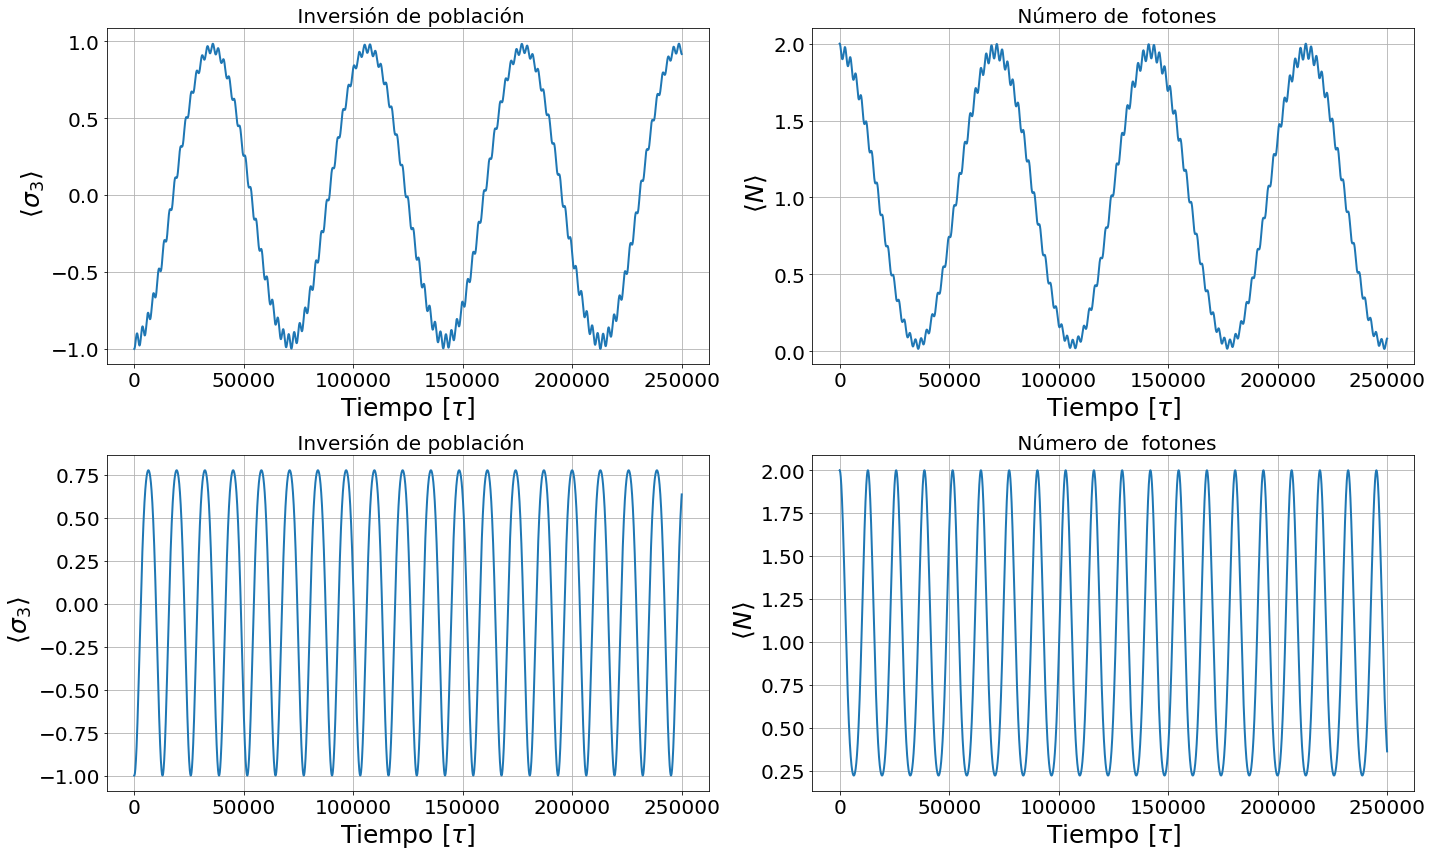

In [177]:
# Definimos el tiempo
M=2
N=2

alpha=[0]

B=Base(M,N)
psi0=B[len(B)-1] #todos los subsistemas inician en el mismo estado |g1g2...gM,N>, todos los átomos en el estado base
sigmas= sigmaT(M,N) 
a=aT(M, N)
n=np.transpose(a)@a 


Sp=np.zeros(sigmas[0].shape)
Sm=np.zeros(sigmas[0].shape)

for i in range(M): #queremos estudiar casa sistema por serado
        sp=sigmas[i]
        sm=np.transpose(sp)
        Sp+=sp
        Sm+=sm

S3=Sp@Sm-Sm@Sp     

N_e=n+Sp@Sm
H1=Hdip0(M, sigmas)
H2=Hrad0(a) 

fig, ax=plt.subplots(2,2, figsize=(20, 12))
                    
#fig.suptitle(r"Evolución temporal partiendo del estado $|g_1,g_2,...,N \rangle$, N={}, M={}".format(N,M), fontsize=24)
for cont in range(2):

        for i in alpha:

                y=R*(1+i)

                P=posiciones2(y,M) #en el ecuador
                momentos=Momentos2(P) #dipolos apuntando en dirección radial

                if cont==0:
                        H=H1+H2+HradI1(M, momentos, sigmas, P, a, y)+ HdipI(M, momentos, sigmas)
                        
                if cont==1:
                        H=H1+H2+HradI1(M, momentos, sigmas, P, a, y) #sin rwa y sin interacción dipolo-dipolo


                result=mesolve( Qobj(H), Qobj(psi0), t, [], [Qobj(S3), Qobj(n)] )

                #result2=mesolve( Qobj(H), Qobj(psi0), t, [], [] )

                plt.tight_layout()

                ax[cont,0].plot(t, (1/M)*result.expect[0], label=r"$\alpha={}$".format(np.round(i,2)),lw=2)
                ax[cont,0].set_title(" Inversión de población", fontsize=20)
                ax[cont,0].tick_params(axis='x', labelsize=20)
                ax[cont,0].tick_params(axis='y', labelsize=20)
                ax[cont,0].set_xlabel(r"Tiempo $[\tau]$", fontsize=25)
                ax[cont,0].set_ylabel(r" $\langle \sigma_3{} \rangle$",fontsize=25)
                ax[cont,0].grid()
                plt.tight_layout()




                ax[cont,1].plot(t, result.expect[1], label=r"$\alpha={}$".format(np.round(i,2)),lw=2)
                ax[cont,1].set_title(" Número de  fotones", fontsize=20)
                ax[cont,1].tick_params(axis='x', labelsize=20)
                ax[cont,1].tick_params(axis='y', labelsize=20)
                ax[cont,1].set_xlabel(r"Tiempo $[\tau]$", fontsize=25)
                ax[cont,1].set_ylabel(r" $\langle N \rangle$",fontsize=25)
                ax[cont,1].grid()
                plt.tight_layout()



fig.savefig('Evolución_temporal.png', format='png', bbox_inches='tight')

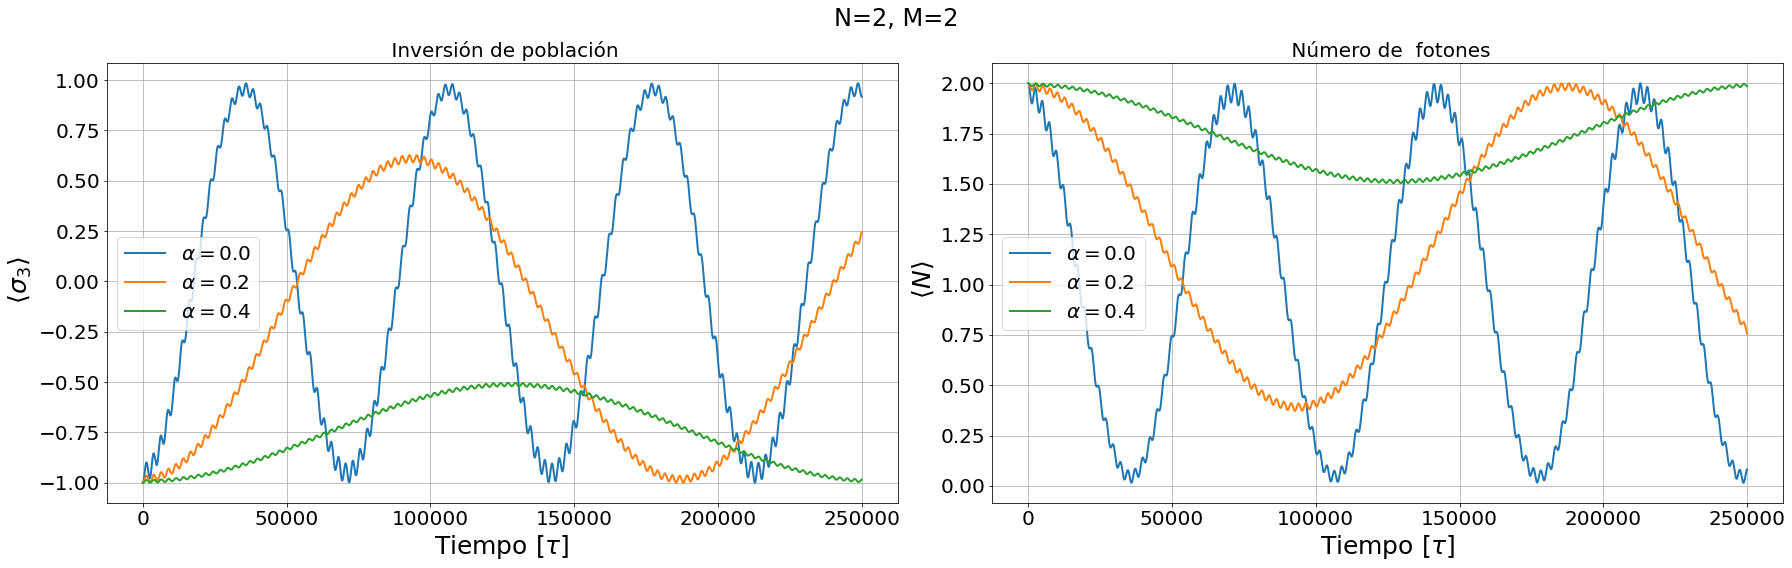

In [173]:
alpha=np.arange(0, 0.6, 0.2)

for S in range (2, 3):

        N=S
        M=S

        B=Base(M,N)
        psi0=B[len(B)-1] #todos los subsistemas inician en el mismo estado |g1g2...gM,N>, todos los átomos en el estado base
        sigmas= sigmaT(M,N) 
        a=aT(M, N)
        n=np.transpose(a)@a 

        Sp=np.zeros(sigmas[0].shape)
        Sm=np.zeros(sigmas[0].shape)

        for i in range(M): #queremos estudiar casa sistema por serado
                sp=sigmas[i]
                sm=np.transpose(sp)
                Sp+=sp
                Sm+=sm

        S3=Sp@Sm-Sm@Sp     

        N_e=n+Sp@Sm
        H1=Hdip0(M, sigmas)
        H2=Hrad0(a) 


        fig, ax=plt.subplots(1,2, figsize=(25,8))
                    
        fig.suptitle(r"N={}, M={}".format(N,M), fontsize=24)

        for i in alpha:

            y=R*(1+i)
            P=posiciones2(y,M) #en el ecuador
            momentos=Momentos2(P) #dipolos apuntando en dirección radial
            H=H1+H2+HradI1(M, momentos, sigmas, P, a, y)+HdipI(M, momentos, sigmas)
            result=mesolve( Qobj(H), Qobj(psi0), t, [], [Qobj(S3), Qobj(n), Qobj(N_e) ]  )

            #result2=mesolve( Qobj(H), Qobj(psi0), t, [], [] )

            
            ax[0].plot(t, (1/M)*result.expect[0], label=r"$\alpha={}$".format(np.round(i,2)),lw=2)
            ax[0].set_title(" Inversión de población", fontsize=20)
            ax[0].tick_params(axis='x', labelsize=20)
            ax[0].tick_params(axis='y', labelsize=20)
            ax[0].set_xlabel(r"Tiempo $[\tau]$", fontsize=25)
            ax[0].set_ylabel(r" $\langle \sigma_3{} \rangle$",fontsize=25)
            ax[0].grid()
            ax[0].legend(fontsize=20)
            plt.tight_layout()




            ax[1].plot(t, result.expect[1], label=r"$\alpha={}$".format(np.round(i,2)),lw=2)
            ax[1].set_title(" Número de  fotones", fontsize=20)
            ax[1].tick_params(axis='x', labelsize=20)
            ax[1].tick_params(axis='y', labelsize=20)
            ax[1].set_xlabel(r"Tiempo $[\tau]$", fontsize=25)
            ax[1].set_ylabel(r" $\langle N \rangle$",fontsize=25)
            ax[1].grid()
            ax[1].legend(fontsize=20)
            plt.tight_layout()

        fig.savefig('Evolución_variada{}.png'.format(S), format='png', bbox_inches='tight')



plt.show()
